In [1]:
from google.colab import files
!pip install -q kaggle
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ashishsaxena2209/animal-image-datasetdog-cat-and-panda

 99% 373M/376M [00:03<00:00, 117MB/s]
100% 376M/376M [00:03<00:00, 106MB/s]


In [3]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

In [4]:
import os
import zipfile
import shutil

local_zip = '/content/animal-image-datasetdog-cat-and-panda.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [5]:
dir_utama = os.path.join('/content/animals')

print(os.listdir(dir_utama))

['images', 'cats', 'panda', 'animals', 'dogs']


In [6]:
ignore_dir = ['images', 'animals']

for dir in ignore_dir:
  path = os.path.join(dir_utama, dir)
  shutil.rmtree(path)

print(os.listdir(dir_utama))

['cats', 'panda', 'dogs']


In [7]:
from PIL import Image
jumlah_sampel = 0

for x in os.listdir(dir_utama):
  dir = os.path.join('/content/animals/', x)
  y = len(os.listdir(dir))
  print(x+':', y)
  jumlah_sampel = jumlah_sampel + y
  
  img_name = os.listdir(dir)
  for z in range(5):
    img_path = os.path.join(dir, img_name[z])
    img = Image.open(img_path)
    print('-',img.size)
  print('---------------')


print('\nJumlah total sampel:', jumlah_sampel)

cats: 1000
- (249, 250)
- (150, 139)
- (500, 497)
- (399, 286)
- (499, 375)
---------------
panda: 1000
- (595, 424)
- (497, 500)
- (500, 375)
- (500, 378)
- (500, 375)
---------------
dogs: 1000
- (369, 500)
- (269, 500)
- (362, 399)
- (500, 374)
- (500, 312)
---------------

Jumlah total sampel: 3000


In [8]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    validation_split = 0.2 # Membagi Data Validasi 20% dan Training 80%
)

In [ ]:
batch_size = 128 

generator_latih = train_datagen.flow_from_directory(
    dir_utama,
    target_size = (150,150), # Besar Input harus sama besar dan dijadikan 150x150
    class_mode = 'categorical', # Menggunakan lebih dari 2 kelas
    batch_size = batch_size,
    subset = 'training' # Penentuan sebagai data latih
)

generator_validasi = train_datagen.flow_from_directory(
    dir_utama, # Direktori sama dengan generator latih karena pembagian dilakukan oleh Generator
    target_size = (150,150),
    class_mode = 'categorical',
    batch_size = batch_size,
    subset = 'validation' # Penentuan sebagai data latih
)

In [ ]:
model = tf.keras.models.Sequential([
    # Besar masukan dibuat sebesar 150x150 dengan warna 3 bytes
    # Konvulasi pertama
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Konvolusi Kedua
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Konvolusi Ketiga
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Konvolusi Keempat
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Meratakan input menjadi 1 dimensi
    tf.keras.layers.Flatten(),
    # Menggunakan Dropout sebesar 50%
    tf.keras.layers.Dropout(0.5), 
    # 512 neuron terhadap hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # 3 neuron/kelas pada output layer
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

model.compile(loss = 'categorical_crossentropy', 
              optimizer = 'rmsprop', # Opmitizer RMSprop
              metrics = ['accuracy'])

In [16]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('accuracy')>0.80 and logs.get('val_accuracy')>0.80) :
      print("\nAkurasi di atas 80%, hentikan pelatihan!")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
history = model.fit(generator_latih, 
                    epochs = 40, 
                    steps_per_epoch = 2400//batch_size, 
                    validation_data = generator_validasi, 
                    verbose = 1, 
                    validation_steps = 600//batch_size,
                    callbacks = [callbacks])

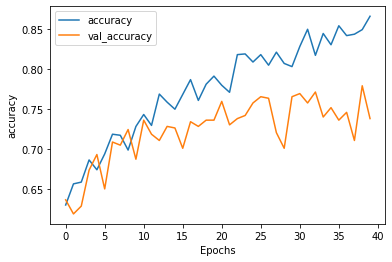

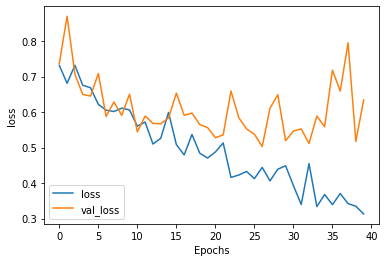

In [18]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
!ls -a